# Import Packages

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sys.path.append('../')

In [3]:
# try:
#     import pyadts
# except:
#     !pip install pyadts

In [4]:
from pyadts.data.repository import get_kpi

# Prepare Data & Pre-processing

In [5]:
data_df, meta_df = get_kpi(root_path='../tests/data/kpi', kpi_id=0)
data_df.head()

,value
timestamp,
2017-04-01 18:08:00,35.03
2017-04-01 18:09:00,36.60
2017-04-01 18:10:00,32.79
2017-04-01 18:11:00,34.28
2017-04-01 18:12:00,34.69


In [6]:
meta_df.head()

,label,timestamp
timestamp,,
2017-04-01 18:08:00,0,1491041280
2017-04-01 18:09:00,0,1491041340
2017-04-01 18:10:00,0,1491041400
2017-04-01 18:11:00,0,1491041460
2017-04-01 18:12:00,0,1491041520


In [7]:
from pyadts.data.preprocessing import series_rearrange
from pyadts.data.preprocessing import series_impute
from pyadts.data.preprocessing import series_normalize

In [8]:
data_df, meta_df = series_rearrange(data_df, meta_df)

[INFO] Before processing, the shape of data: (295385, 1).
[INFO] Detected minimum interval: 0 days 00:01:00.
[INFO] After processing, the shape of data: (295385, 1).


In [9]:
data_df.head()

,value
2017-04-01 18:08:00,35.03
2017-04-01 18:09:00,36.60
2017-04-01 18:10:00,32.79
2017-04-01 18:11:00,34.28
2017-04-01 18:12:00,34.69


In [10]:
meta_df.head()

,label,timestamp
2017-04-01 18:08:00,0,1491041280
2017-04-01 18:09:00,0,1491041340
2017-04-01 18:10:00,0,1491041400
2017-04-01 18:11:00,0,1491041460
2017-04-01 18:12:00,0,1491041520


In [11]:
from pyadts.utils.visualization import plot_series

<ipython-input-12-52caadc0f650>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


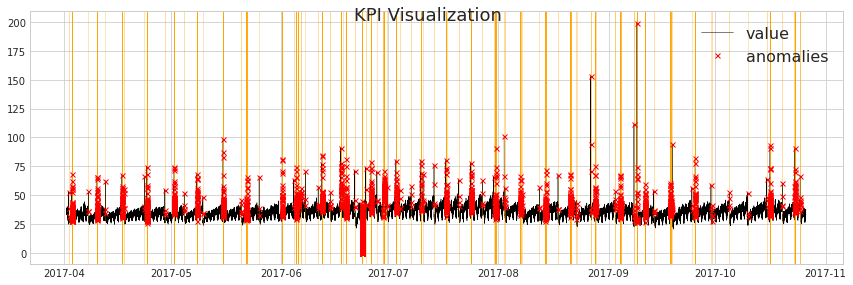

In [12]:
%matplotlib inline
fig = plot_series(data_df, meta_df, title='KPI Visualization')
fig.show()


In [13]:
series_impute(data_df, method='linear')
series_normalize(data_df, method='zscore')

<ipython-input-14-89f652a3b477>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


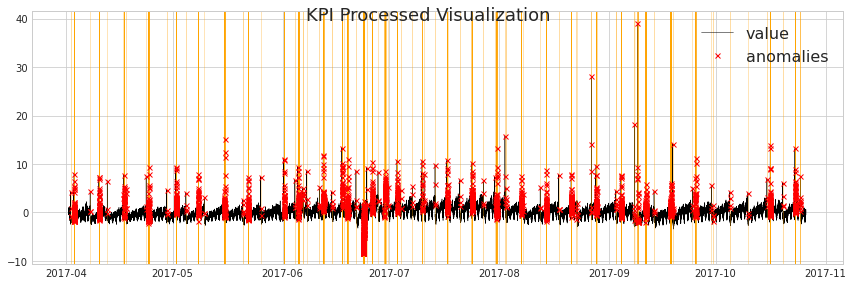

In [14]:
fig = plot_series(data_df, meta_df, title='KPI Processed Visualization')
fig.show()


# Feature Extraction

In [15]:
from pyadts.data.feature import get_all_features

In [16]:
features = get_all_features(data_df, get_stl=False, window_list=[10, 100])

[INFO] Processing spectral residual feature...
[INFO] Processing simple features...
[INFO] Processing SARIMA features...


..\pyadts\data\feature\__simple_features.py:5: RuntimeWarning: invalid value encountered in log
  return np.log(value)


[INFO] Processing ExponentialSmoothing features...


D:\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


[INFO] Processing Holt features...
[INFO] Processing SimpleExpSmoothing features...


SLIDING_WINDOW:   1%|▎                                                         | 1497/299033 [00:00<00:40, 7333.65it/s]

[INFO] Processing wavelet features...
[INFO] Processing window features...


SLIDING_WINDOW: 100%|████████████████████████████████████████████████████████| 298853/298853 [00:32<00:00, 9141.69it/s]


<ipython-input-17-cfc8b93e6d7b>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


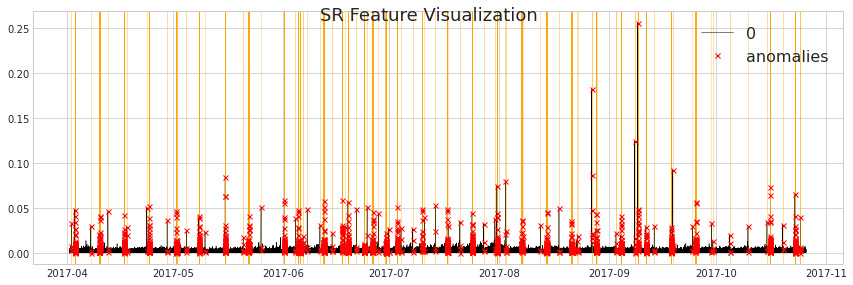

In [17]:
fig = plot_series(features.iloc[:, 0:1], meta_df.iloc[-features.shape[0]:,:], title='SR Feature Visualization')
fig.show()

In [18]:
from pyadts.data.utils import train_test_split

In [19]:
train_data, train_meta, test_data, test_meta = train_test_split(features, meta_df, train_ratio=0.7)

# Anomaly Detection with Supervised Classifiers

In [20]:
from pyadts.model.supervised import SVM

In [21]:
clf = SVM(kernel='rbf')

In [22]:
clf.fit(train_data.values, train_meta.label)

In [29]:
scores = clf.predict_score(test_data.values)
predictions = clf.predict(test_data.values)

In [25]:
from pyadts.evaluation.metrics import roc_auc, pr_auc

In [35]:
roc_auc(score=scores, label=test_meta.label[200:].values, delay=7)

0.6248743965052181

In [36]:
pr_auc(score=scores, label=test_meta.label[200:].values, delay=7)

0.02813450063987292

# Anomaly Detection with Non-parametric Unsupervised Models

In [20]:
from pyadts.model.streaming import SpectralResidual

In [21]:
sr = SpectralResidual()

In [22]:
sr.fit(data_df.values.reshape(-1))

In [23]:
scores = sr.predict_score(data_df.values.reshape(-1))

In [29]:
roc_auc(score=scores, label=meta_df.label.values, delay=7)

0.9585120165583487

In [28]:
pr_auc(score=scores, label=meta_df.label.values, delay=7)

0.8634257006176141